In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
import functions
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

TRAIN_DIR = "train"
TEST_DIR = "test"

In [2]:
def predictAccuracy(y1, y2, cutoff = .5):
    return sum([a == (b >= cutoff) for a,b in zip(y1,y2)]) / float(len(y1))

def cv_optimize(clf, parameters, X, y, n_jobs, n_folds, score_func, verbose):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, verbose=verbose, scoring=score_func)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best, gs.best_params_

def do_classify(clf, parameters, X, y, mask=None, n_folds=5, n_jobs=4, verbose=False, score_func=None):
    if mask is None:
        print "Test"
        mask = functions.split_mask(X)
    X_train, X_cv, y_train, y_cv = X[mask], X[~mask], y[mask], y[~mask]
    clf, best_params_ = cv_optimize(clf, parameters, X_train, y_train, n_jobs=n_jobs, n_folds=n_folds, verbose=verbose, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    cv_preds = clf.predict(X_cv)
    training_accuracy = predictAccuracy(y_train, train_preds, .5)
    cv_accuracy = predictAccuracy(y_cv, cv_preds)
    if verbose:
        print "Training classes"
        print training_accuracy
        print "############# based on standard predict ################"
        print "Accuracy on training data: %0.4f" % training_accuracy
        print "Accuracy on crossv data:   %0.4f" % cv_accuracy
        print "########################################################"
    return clf, X_train, y_train, X_cv, y_cv, best_params_

In [3]:
X, y, ids, call_list = functions.create_data_matrix(direc=TRAIN_DIR, verbose=True)

Number of datafiles loaded: 3086


In [4]:
X.shape

(3086L, 106L)

In [8]:
X_ = pd.DataFrame(X, columns = call_list)
X_.shape

(3086, 106)

In [9]:
mask = functions.split_mask(X_, .99)

In [10]:
clfForest = RandomForestClassifier()
clfForestRegressor = RandomForestRegressor()
parameters = {
#    "n_estimators" : [100],
#    "n_estimators" : [100,200,400,800],
#    "max_depth": [25]
#    "max_depth": [100,200,400,None]
}

In [11]:
y_morphed = np.array([0 if y_ == 8 else 1 for y_ in y])

In [12]:
y_lists = []
for y_ in range(15):
    y_lists.append(np.array([1 if y__ == y_ else 0 for y__ in y]))

In [13]:
%%time
forests = []
for lst in y_lists:
    clfForest_test, _, _, X_cv, y_cv, best_params = do_classify(clfForestRegressor, parameters, X_, lst, mask=mask, n_folds = 3, n_jobs = 1, verbose=False)
    forests.append(clfForest_test)

BEST {} 0.118439339256 [mean: 0.11844, std: 0.12055, params: {}]
BEST {} 0.418443418316 [mean: 0.41844, std: 0.05484, params: {}]
BEST {} 0.350070915319 [mean: 0.35007, std: 0.20846, params: {}]
BEST {} 0.684640781697 [mean: 0.68464, std: 0.16035, params: {}]
BEST {} 0.397647651151 [mean: 0.39765, std: 0.09827, params: {}]
BEST {} 0.511057759475 [mean: 0.51106, std: 0.16958, params: {}]
BEST {} 0.913525405915 [mean: 0.91353, std: 0.02582, params: {}]
BEST {} 0.656152831029 [mean: 0.65615, std: 0.02514, params: {}]
BEST {} 0.7805384997 [mean: 0.78054, std: 0.00696, params: {}]
BEST {} 0.163962101771 [mean: 0.16396, std: 0.05666, params: {}]
BEST {} 0.974989742678 [mean: 0.97499, std: 0.00534, params: {}]
BEST {} 0.465668899266 [mean: 0.46567, std: 0.05075, params: {}]
BEST {} 0.807983524441 [mean: 0.80798, std: 0.04328, params: {}]
BEST {} 0.0319655911468 [mean: 0.03197, std: 0.01086, params: {}]
BEST {} 0.689926397486 [mean: 0.68993, std: 0.06125, params: {}]
Wall time: 12.4 s


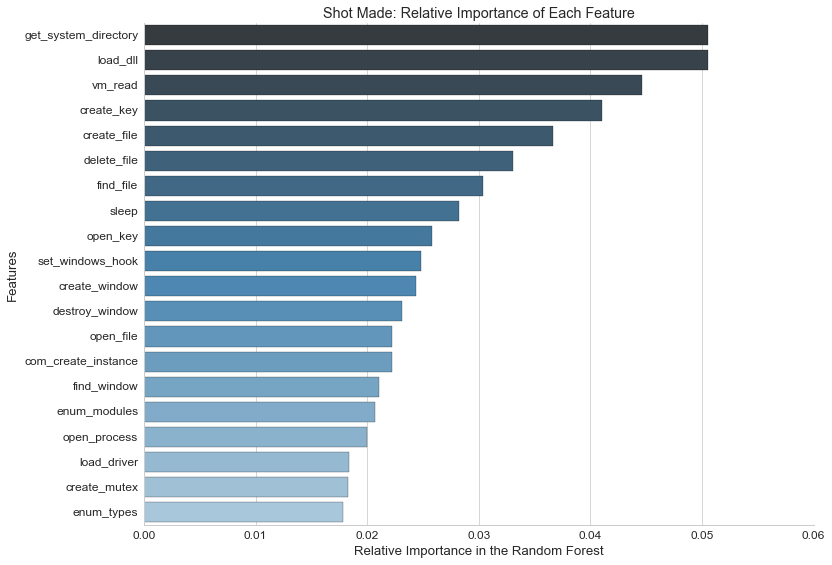

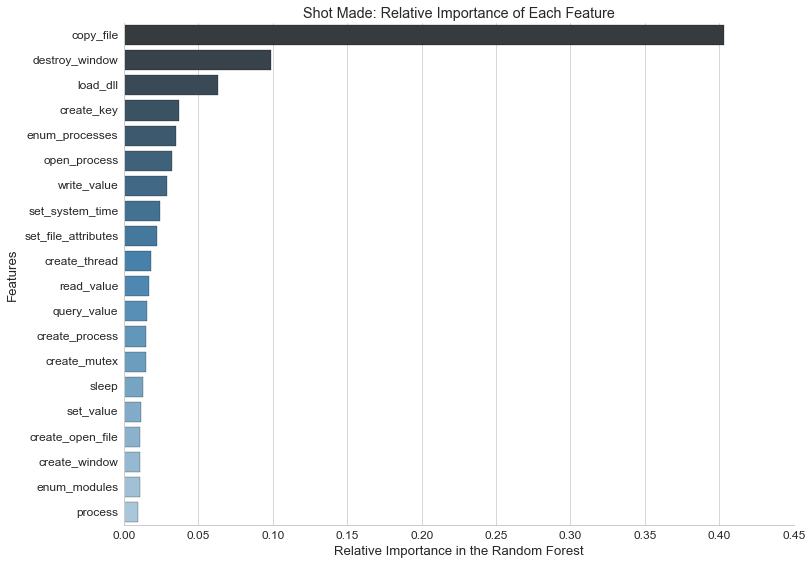

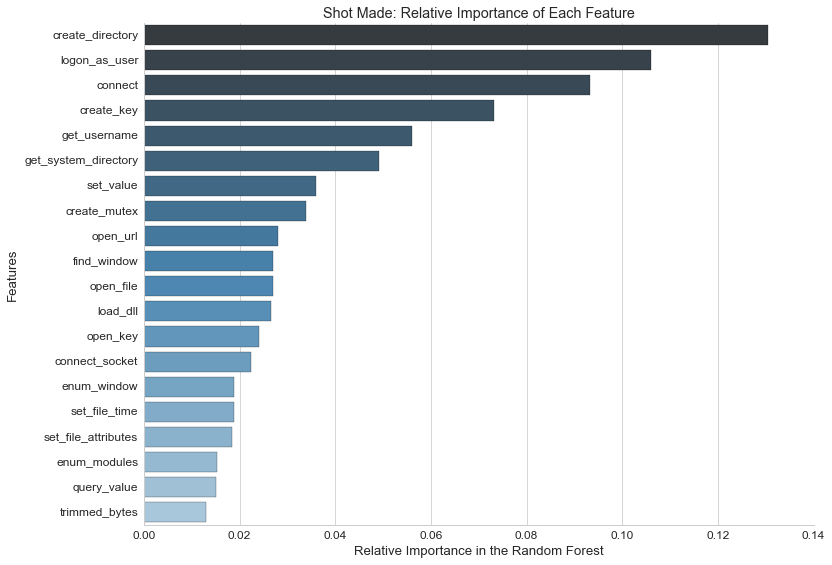

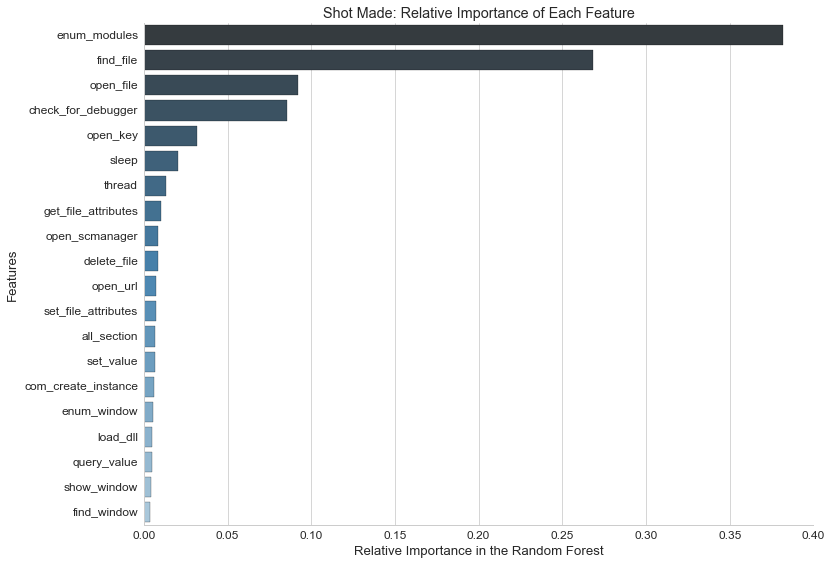

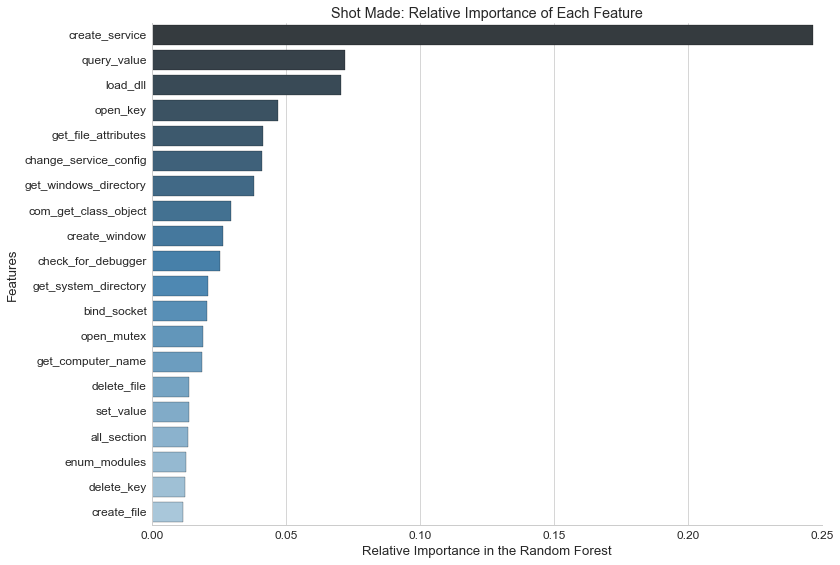

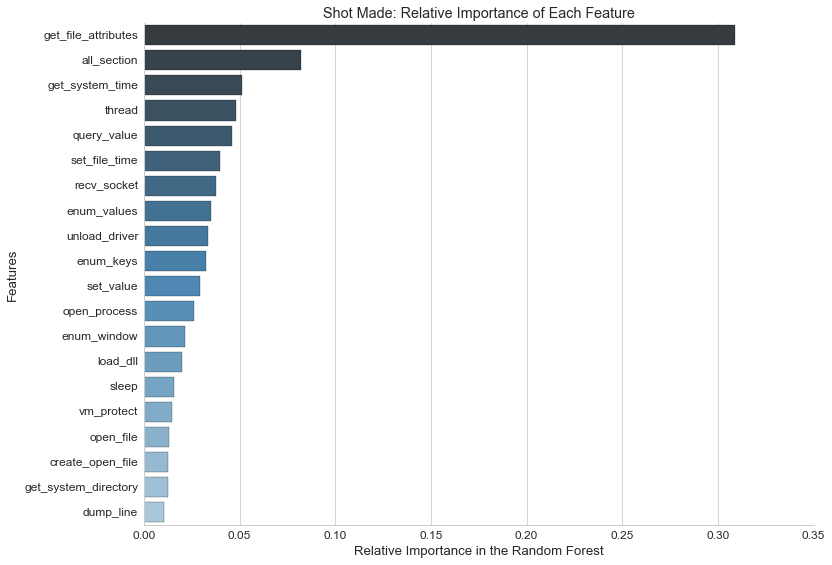

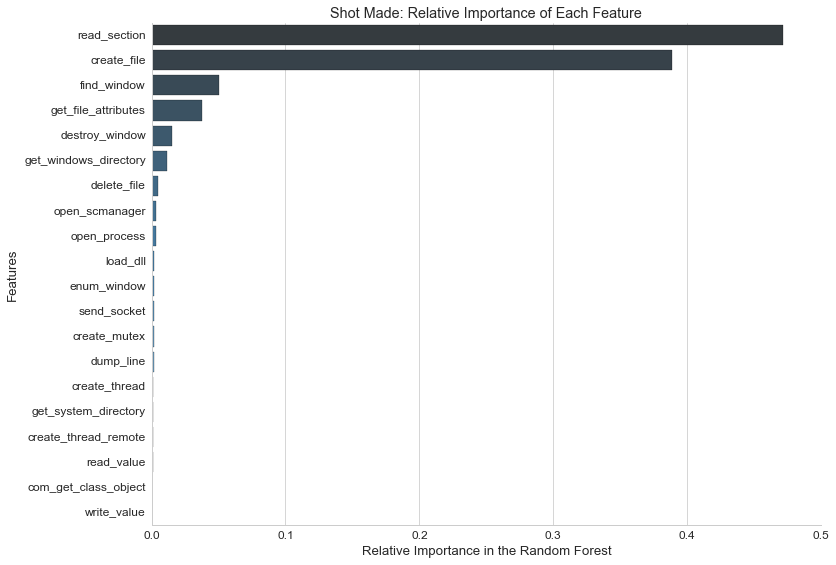

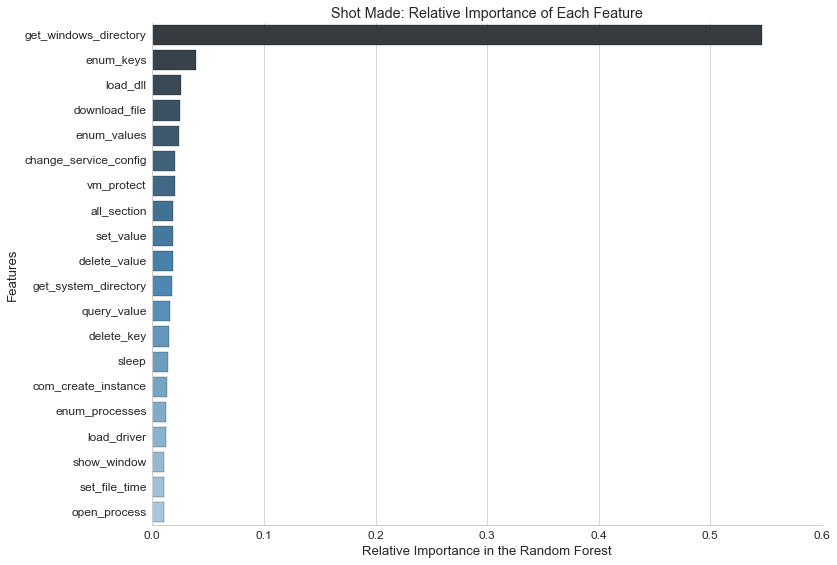

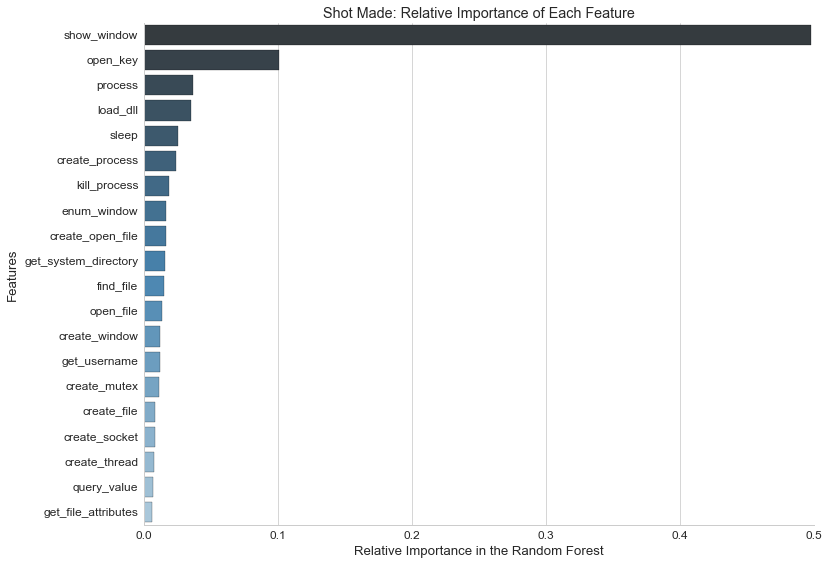

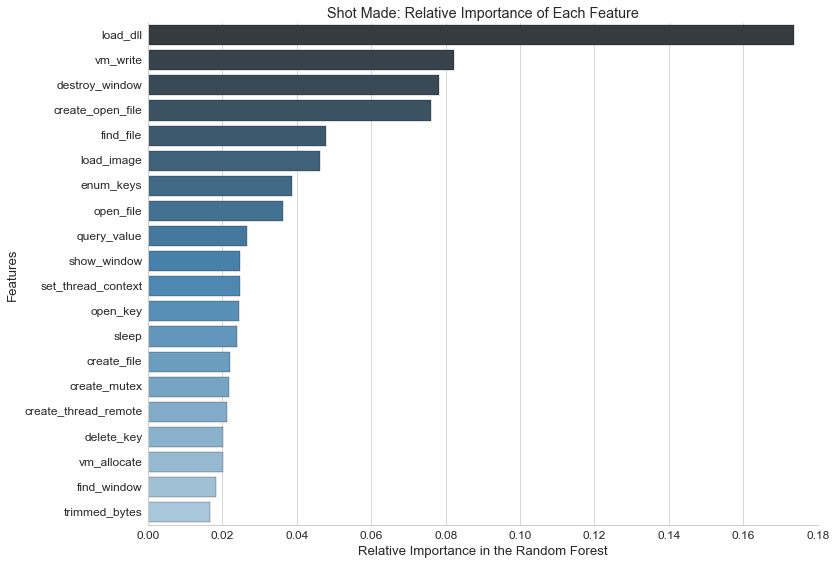

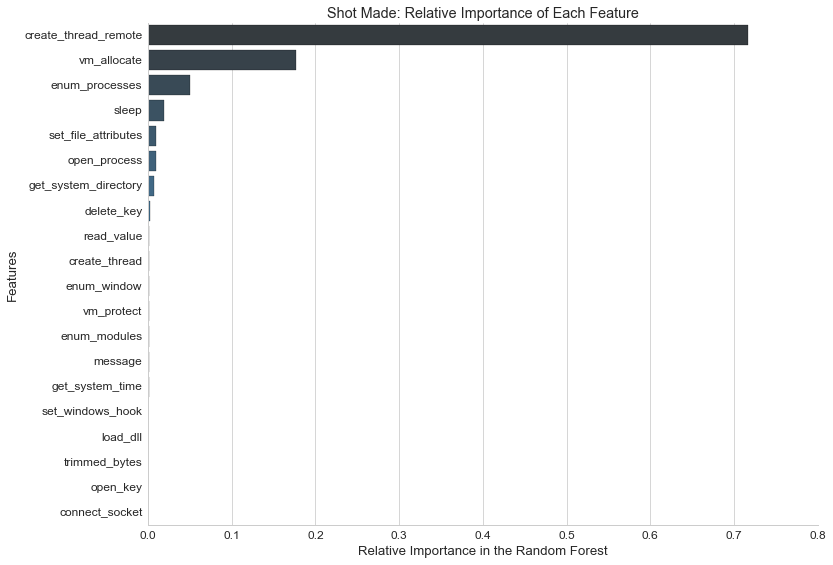

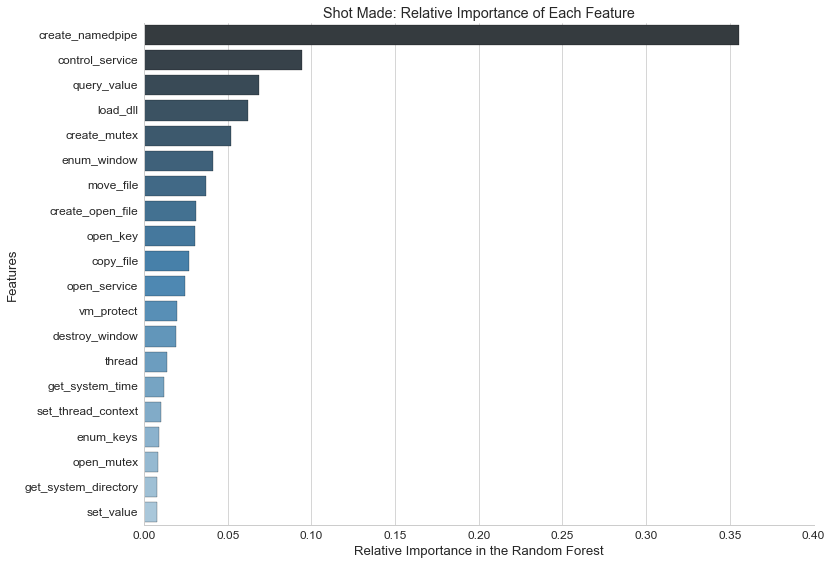

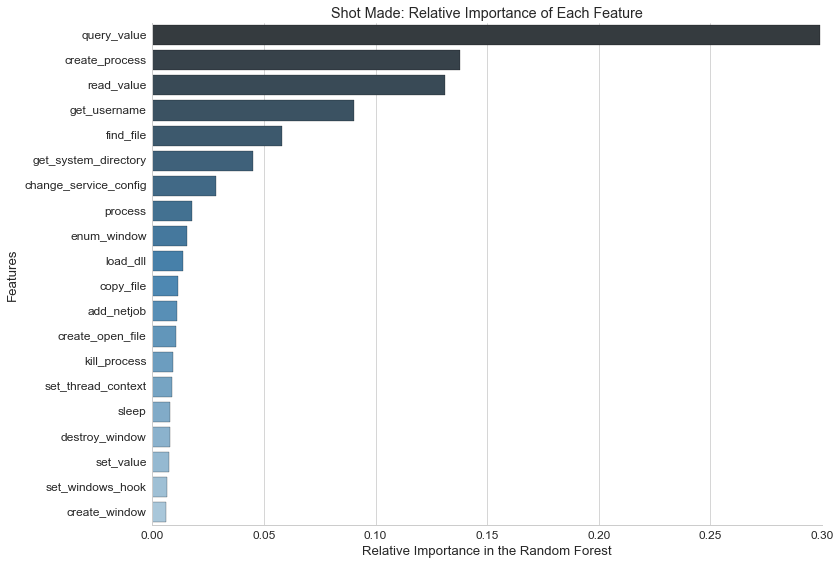

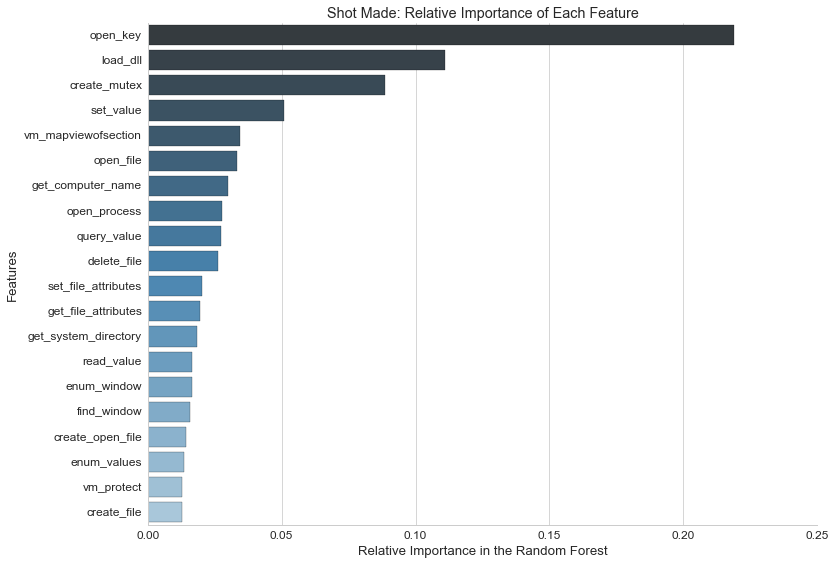

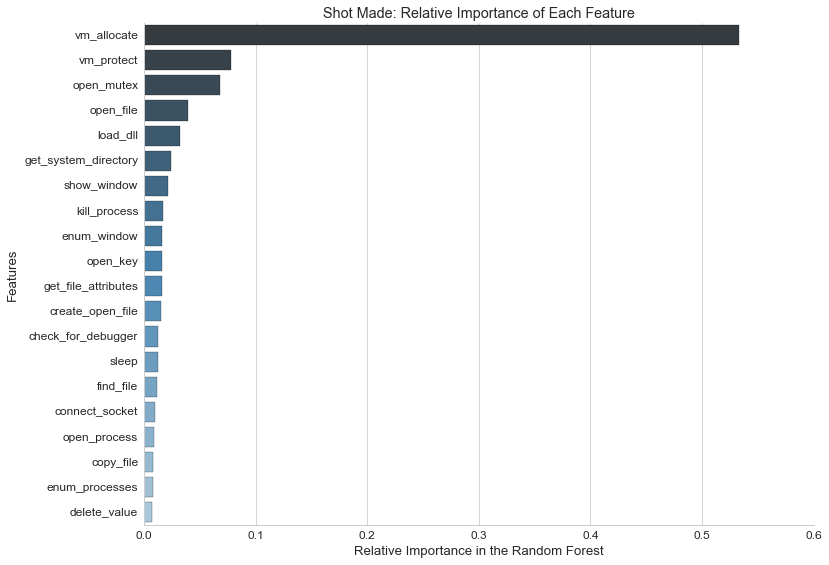

In [20]:
for f in forests:
    importance_list = f.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, X_.columns)))
    sns.set_context("paper", font_scale=1.5)
    plt.figure(figsize=(12, 9))
    ax = sns.barplot(y=range(20),x=list(reversed(importance_list))[:20], orient='h', palette="Blues_d")
    ax.set_xlabel('Relative Importance in the Random Forest')
    ax.set_ylabel('Features')
    ax.set_title('Shot Made: Relative Importance of Each Feature')
    ax.set_yticklabels(list(reversed(name_list)));
    sns.despine()
    #plt.savefig('Baseline Relative Importance.png', bbox_inches='tight')

In [99]:
X_cv, y_cv = X[~mask], y[~mask]

In [100]:
def predict(preds):
    return np.array([np.argmax(p) for p in zip(*np.array(preds))])

def accuracy(preds, actual):
    return sum([a == b for a,b in zip(preds, actual)]) / float(len(preds))    

In [102]:
#preds_mat = [f.predict(X_cv) for f in forests]

In [103]:
#preds = predict(preds_mat)

In [104]:
#accuracy(preds, y_cv)

In [66]:
X_test, y_test, ids, _ = functions.create_data_matrix(direc=TEST_DIR, verbose=True, call_list=call_list)

Number of datafiles loaded: 3724


In [105]:
print X_test.shape

(3724L, 106L)


In [106]:
X_test_ = poly.fit_transform(X_test)
print X_test_.shape

(3724L, 5672L)


In [107]:
preds_mat_act = [f.predict(X_test_) for f in forests]

In [114]:
test = pd.DataFrame(preds_mat_act).T

In [108]:
preds_act = predict(preds_mat_act)

In [71]:
# We have predictions!!!!

In [109]:
functions.write_to_file("submissions/RandForest_mult_3.csv", ids, preds_act)